In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, LSTM, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
data = pd.read_csv('TCS_Stock_Price_Index.csv')

In [3]:
data.dropna(inplace = True)
data

,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
0,10-August-2023,3444.05,3455.00,3431.00,3443.45,3443.986255,85997,7887,296172486.0,60272,70.09,24.00,-0.60
1,9-August-2023,3469.00,3469.00,3425.00,3464.00,3453.612004,53047,3237,183203756.0,38575,72.72,44.00,-5.00
2,8-August-2023,3483.85,3487.50,3457.10,3469.85,3471.119494,81770,5750,283833441.0,69584,85.10,30.40,-14.00
3,7-August-2023,3443.00,3487.75,3442.00,3483.75,3459.901923,48564,4574,168026677.0,26833,55.25,45.75,40.75
4,4-August-2023,3391.10,3470.15,3391.10,3442.30,3443.948753,73311,4643,252479327.0,15154,20.67,79.05,51.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,17-August-2018,2014.00,2021.15,2005.00,2011.85,2009.350547,175463,3695,352566675.0,125236,71.37,16.15,-2.15
1233,16-August-2018,2002.00,2019.00,1996.00,2008.75,2010.169134,132552,4513,266451939.0,49123,37.06,23.00,6.75
1234,14-August-2018,1992.00,2024.00,1983.50,2001.25,2012.207129,228939,9779,460672688.0,95394,41.67,40.50,9.25
1235,13-August-2018,2000.00,2002.55,1988.25,2000.50,1996.705438,364314,9039,727427745.0,266747,73.22,14.30,0.50


## Moving Date to index, It is easier to track

In [4]:
data['Date'] = pd.to_datetime(data['Date'], format="%d-%B-%Y")
data.index = data.pop('Date')
data

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
Date,,,,,,,,,,,,
2023-08-10,3444.05,3455.00,3431.00,3443.45,3443.986255,85997,7887,296172486.0,60272,70.09,24.00,-0.60
2023-08-09,3469.00,3469.00,3425.00,3464.00,3453.612004,53047,3237,183203756.0,38575,72.72,44.00,-5.00
2023-08-08,3483.85,3487.50,3457.10,3469.85,3471.119494,81770,5750,283833441.0,69584,85.10,30.40,-14.00
2023-08-07,3443.00,3487.75,3442.00,3483.75,3459.901923,48564,4574,168026677.0,26833,55.25,45.75,40.75
2023-08-04,3391.10,3470.15,3391.10,3442.30,3443.948753,73311,4643,252479327.0,15154,20.67,79.05,51.20
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-17,2014.00,2021.15,2005.00,2011.85,2009.350547,175463,3695,352566675.0,125236,71.37,16.15,-2.15
2018-08-16,2002.00,2019.00,1996.00,2008.75,2010.169134,132552,4513,266451939.0,49123,37.06,23.00,6.75
2018-08-14,1992.00,2024.00,1983.50,2001.25,2012.207129,228939,9779,460672688.0,95394,41.67,40.50,9.25


# Doing a train test split
In this way, we will train our model with data with last 80% from the latest date and testing our model with recent 20% data.

In [5]:
# for doing train test split in ratio 4:1, where last 80% will be training data and recent 20% will be test data

x = int(len(data) * 0.2)
train_data = data.iloc[x:, 4:5]
test_data = data.iloc[:x, 4:5]
print(train_data)
print(test_data)

                    WAP
Date                   
2022-08-11  3412.815892
2022-08-10  3356.480808
2022-08-08  3362.590256
2022-08-05  3365.202545
2022-08-04  3350.282240
...                 ...
2018-08-17  2009.350547
2018-08-16  2010.169134
2018-08-14  2012.207129
2018-08-13  1996.705438
2018-08-10  1987.696566

[990 rows x 1 columns]
                    WAP
Date                   
2023-08-10  3443.986255
2023-08-09  3453.612004
2023-08-08  3471.119494
2023-08-07  3459.901923
2023-08-04  3443.948753
...                 ...
2022-08-19  3393.811953
2022-08-18  3375.408830
2022-08-17  3404.370226
2022-08-16  3398.788246
2022-08-12  3397.804473

[247 rows x 1 columns]


# Plotting the Stock Price with Date/ Year

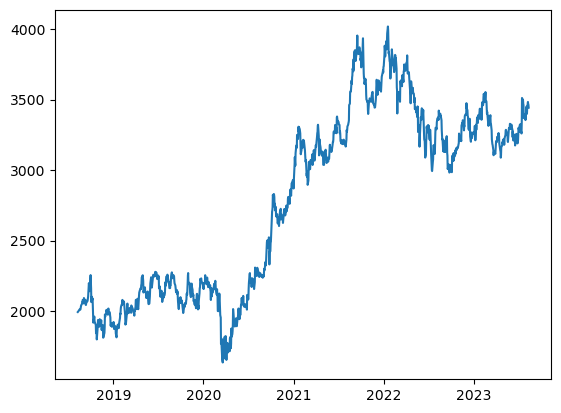

In [6]:
plt.plot(data.index, data['Close Price'])

# Normalisation to increase the accuracy of the model

In [18]:
scaler = MinMaxScaler(feature_range = (0,1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)
print(train_data.shape)
print(test_data.shape)

(990, 1)
(247, 1)


# Compiling the Neural Network

In [45]:
length = 60 # for number of timesteps
batch_size = 20
generator = TimeseriesGenerator(train_data, train_data, length = length, batch_size = batch_size)
n_features = 1
model = Sequential([LSTM(units = 128, activation = 'tanh', recurrent_activation = 'sigmoid', return_sequences =True,
                         input_shape= (train_data.shape[1], 1)),
                    LSTM(64, return_sequences = True),
                    Dense(units = 1)])
model.compile(optimizer = 'adam', loss = 'mse')

In [46]:
train_history = model.fit(generator, epochs = 50, shuffle = False)

Epoch 1/50
47/47 [==============================] - 5s 42ms/step - loss: 0.0629
Epoch 2/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0312
Epoch 3/50
47/47 [==============================] - 2s 46ms/step - loss: 0.0422
Epoch 4/50
47/47 [==============================] - 2s 44ms/step - loss: 0.0441
Epoch 5/50
47/47 [==============================] - 2s 45ms/step - loss: 0.0457
Epoch 6/50
47/47 [==============================] - 2s 45ms/step - loss: 0.0529
Epoch 7/50
47/47 [==============================] - 2s 44ms/step - loss: 0.0510
Epoch 8/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0471
Epoch 9/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0398
Epoch 10/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0330
Epoch 11/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0278
Epoch 12/50
47/47 [==============================] - 2s 44ms/step - loss: 0.0231
Epoch 13/50
47/47 [==================

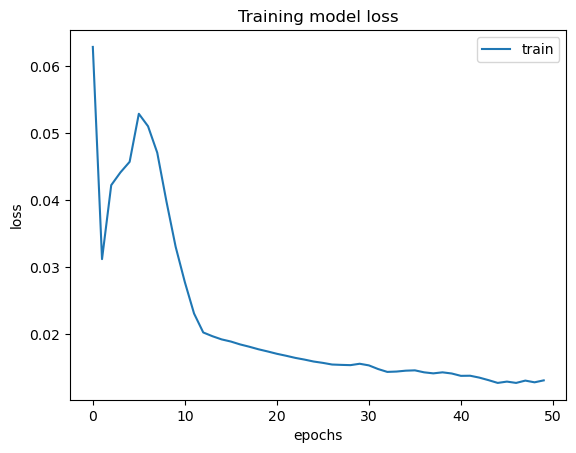

In [51]:
plt.plot(train_history.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc = 'upper right')
plt.show()

# Testing the model

In [52]:
y_pred = model.predict(test_data)
y_pred_reshaped = y_pred.reshape(-1,1)
y_pred_reshaped.shape

8/8 [==============================] - 0s 3ms/step


(247, 1)

In [53]:
predicted_price = scaler.inverse_transform(y_pred_reshaped)
actual_price = scaler.inverse_transform(test_data)

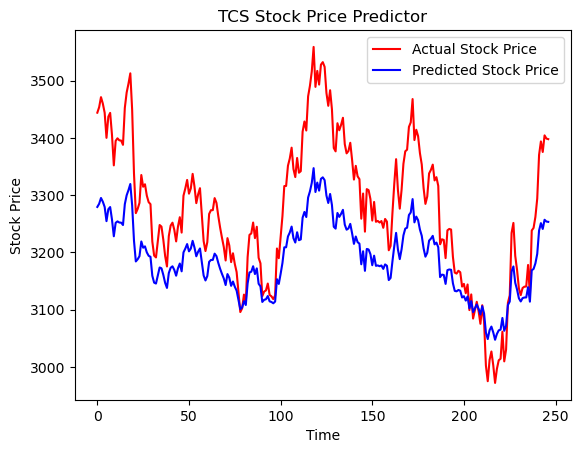

In [50]:
plt.plot(actual_price, 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, 'blue', label = 'Predicted Stock Price')
plt.title('TCS Stock Price Predictor')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()